In [4]:
import torch.nn as nn
import torch
from learned_dict import TiedSAE
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from transformers import ViTForImageClassification, ViTImageProcessor
from util import ActivationDataset, plot_activation
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
from collections import Counter


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model = 'nateraw/vit-base-patch16-224-cifar10'
model = ViTForImageClassification.from_pretrained(vit_model, output_hidden_states=True).to(device)

model.eval()
feature_extractor = ViTImageProcessor.from_pretrained(vit_model)
to_pil = transforms.ToPILImage()

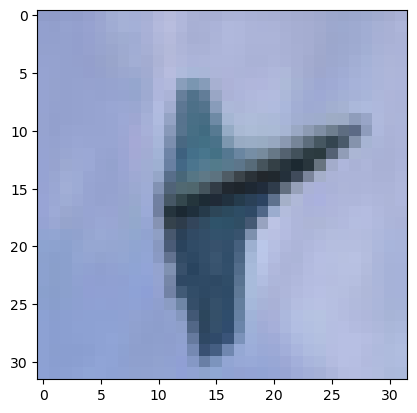

In [6]:
# Create a DataLoader
dataset = ActivationDataset('activations_cifar10_vit_b/cifar10_activations_0.h5','vit.encoder.layer.0.output')

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
input_image = next(iter(data_loader))[0][0]
plt.imshow(input_image.permute(1,2,0))
inputs = feature_extractor(images=to_pil(input_image), return_tensors="pt")

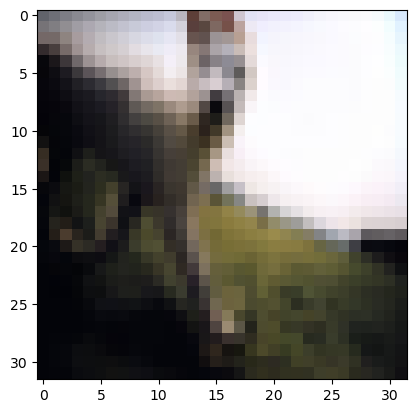

In [7]:
# Create a DataLoader2
dataset2 = ActivationDataset('activations_cifar10_vit_b/cifar10_activations_5.h5','vit.encoder.layer.0.output')

data_loader2 = DataLoader(dataset2, batch_size=32, shuffle=True)

input_image2 = next(iter(data_loader2))[0][0]
plt.imshow(input_image2.permute(1,2,0))

inputs2 = feature_extractor(images=to_pil(input_image2), return_tensors="pt")

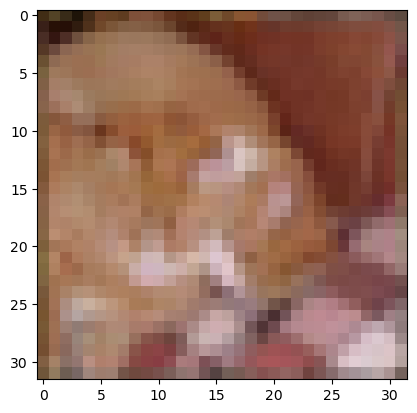

In [8]:
# Create a DataLoader
dataset3 = ActivationDataset('activations_cifar10_vit_b/cifar10_activations_3.h5','vit.encoder.layer.0.output')

data_loader3 = DataLoader(dataset3, batch_size=32, shuffle=True)

input_image3 = next(iter(data_loader3))[0][0]
plt.imshow(input_image3.permute(1,2,0))

inputs3 = feature_extractor(images=to_pil(input_image3), return_tensors="pt")

# Look into individual features activated with x15 model

layer 0


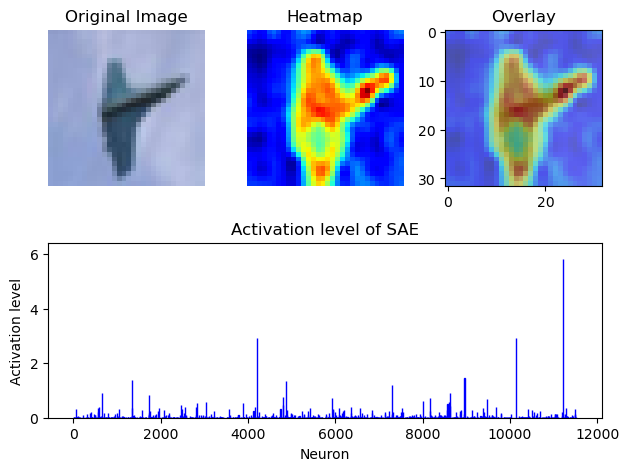

layer 1


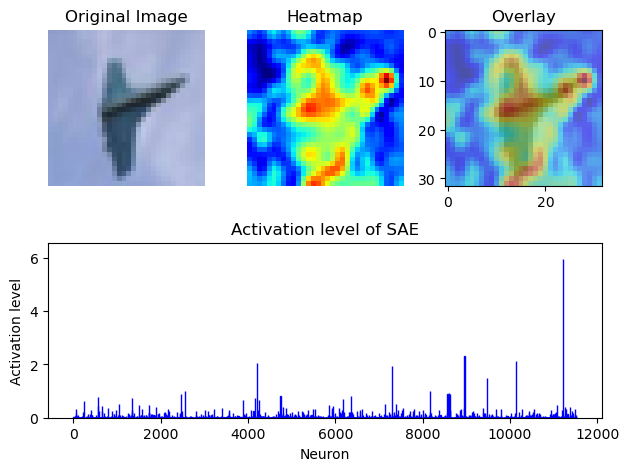

layer 2


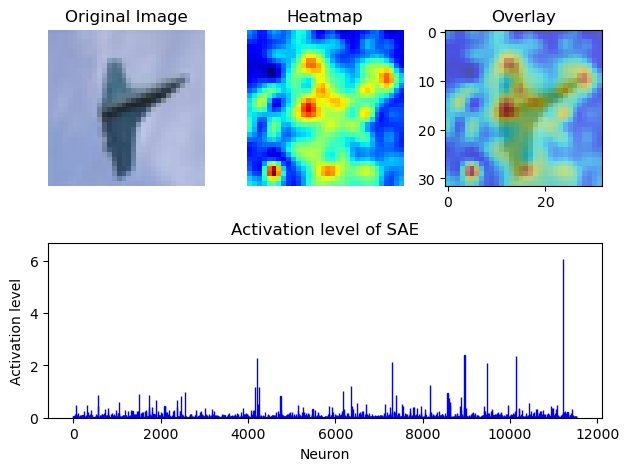

layer 3


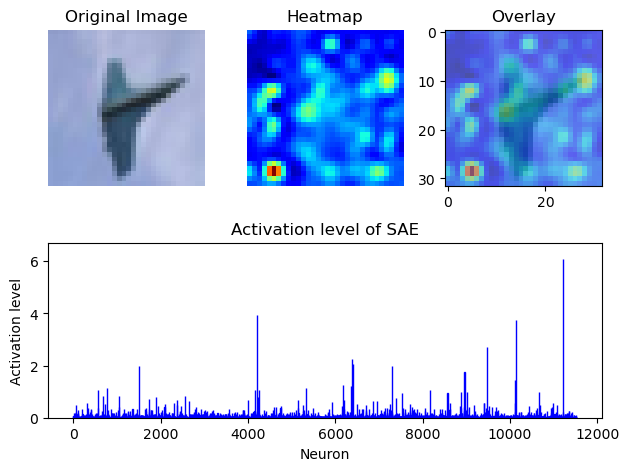

layer 4


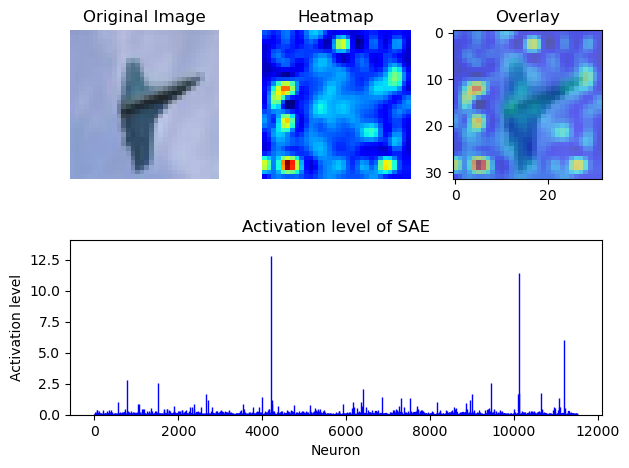

layer 5


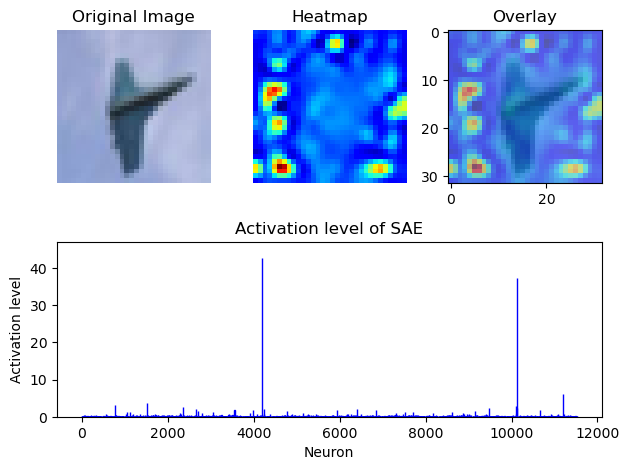

layer 6


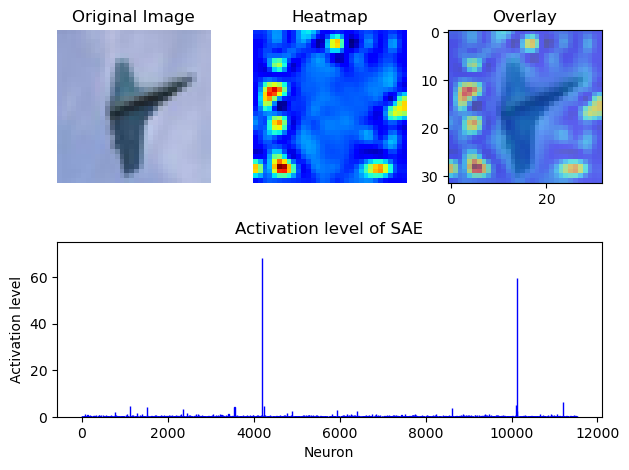

layer 7


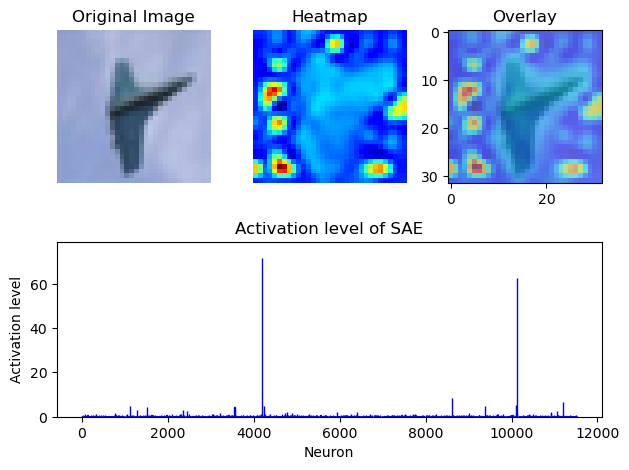

layer 8


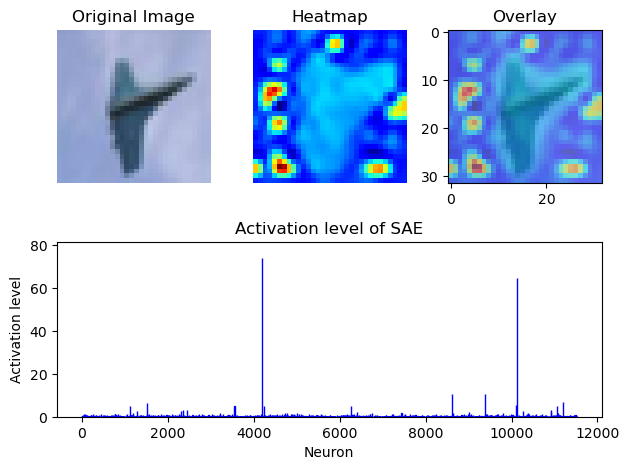

layer 9


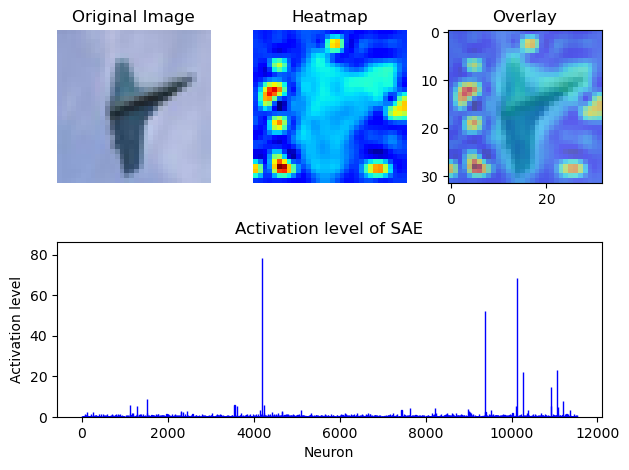

layer 10


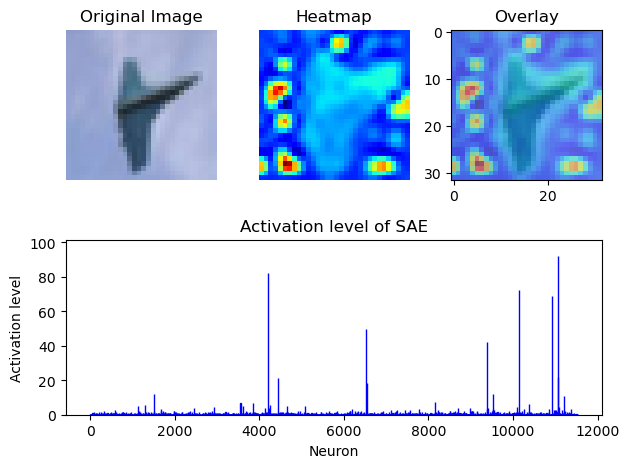

layer 11


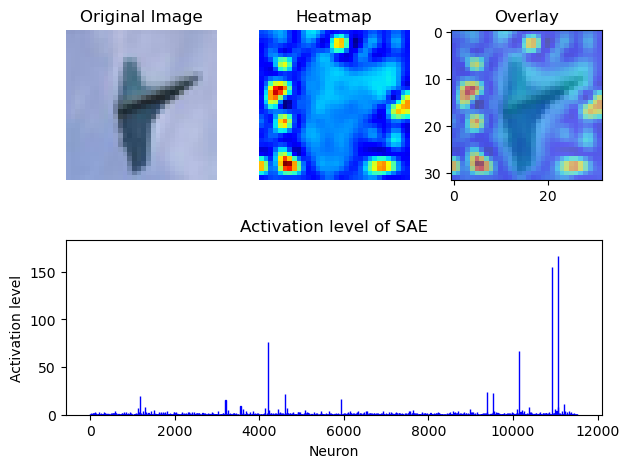

layer 0


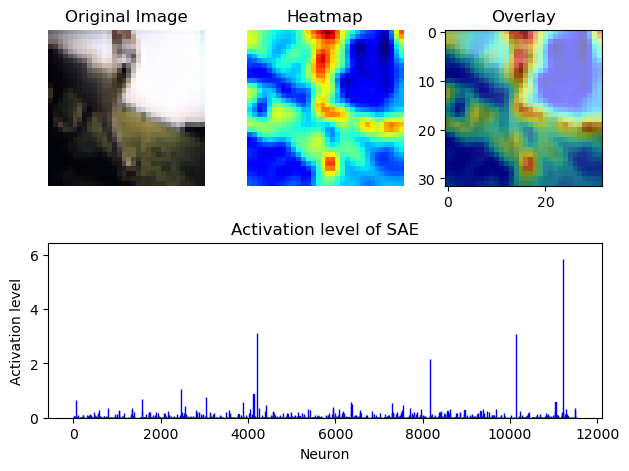

layer 1


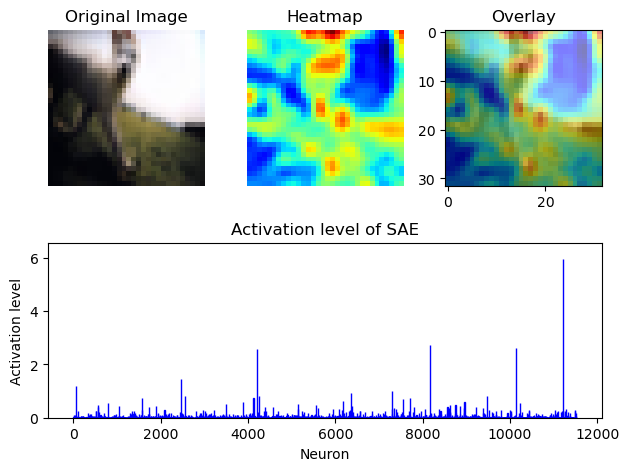

layer 2


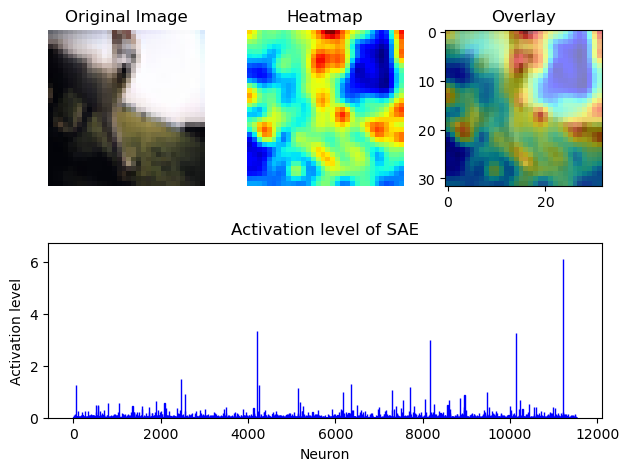

layer 3


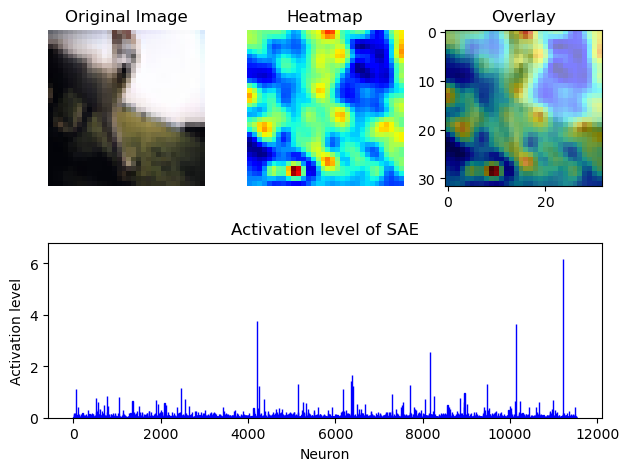

layer 4


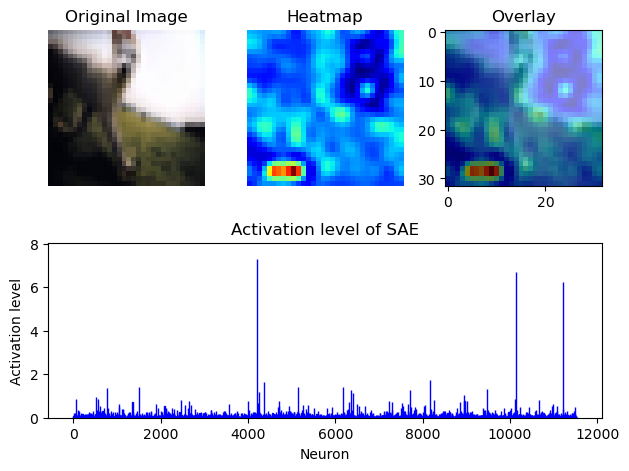

layer 5


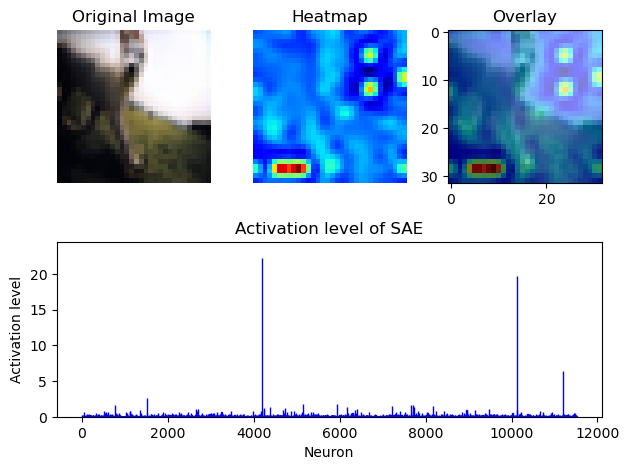

layer 6


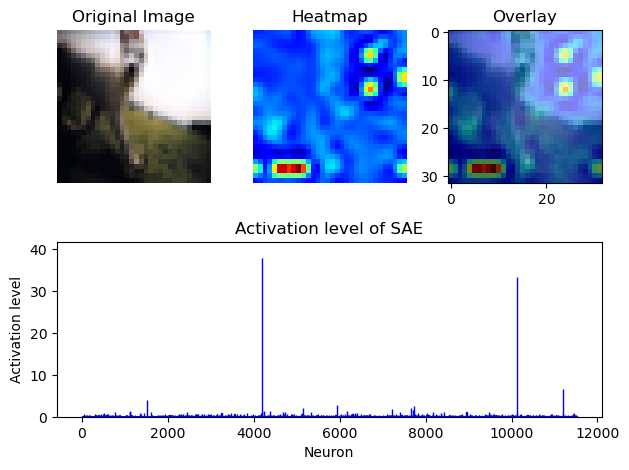

layer 7


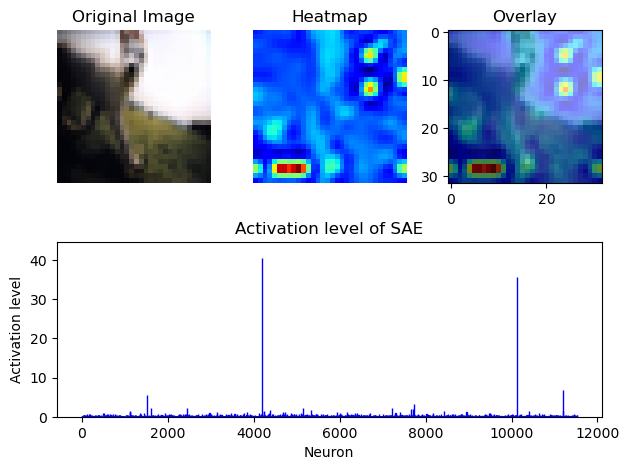

layer 8


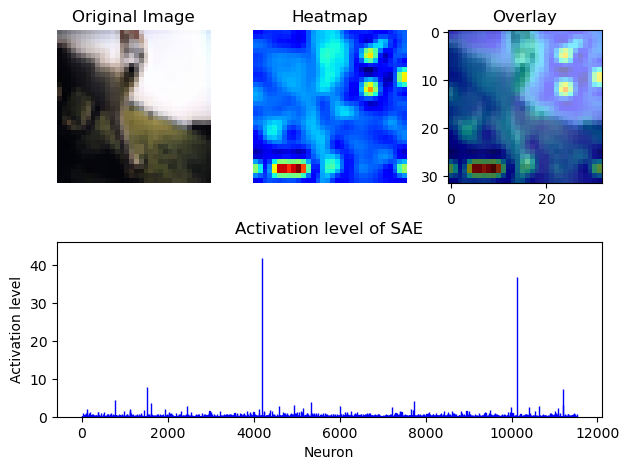

layer 9


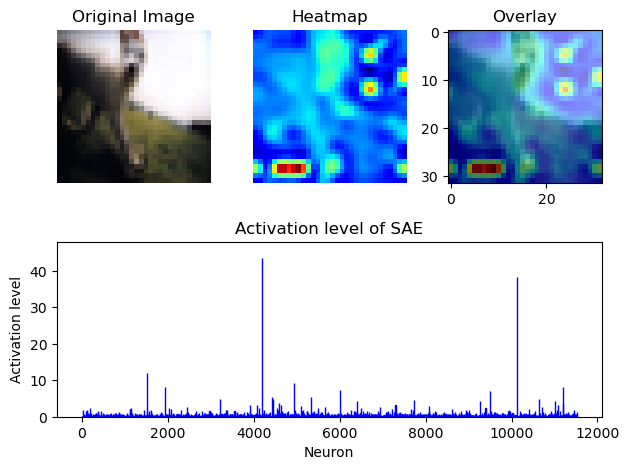

layer 10


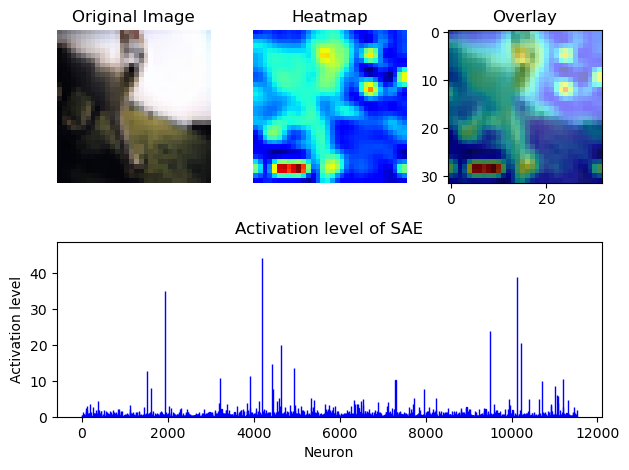

layer 11


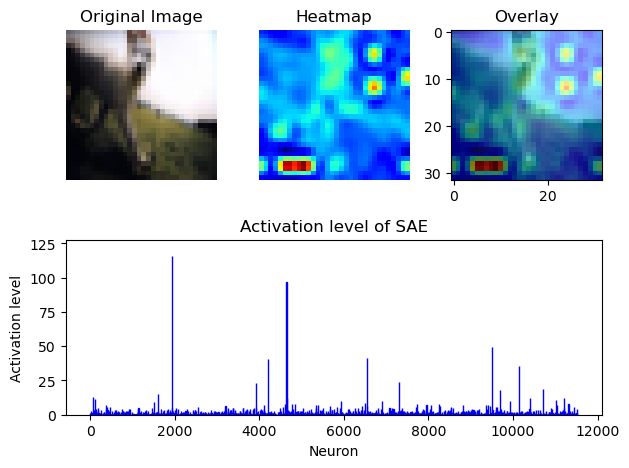

layer 0


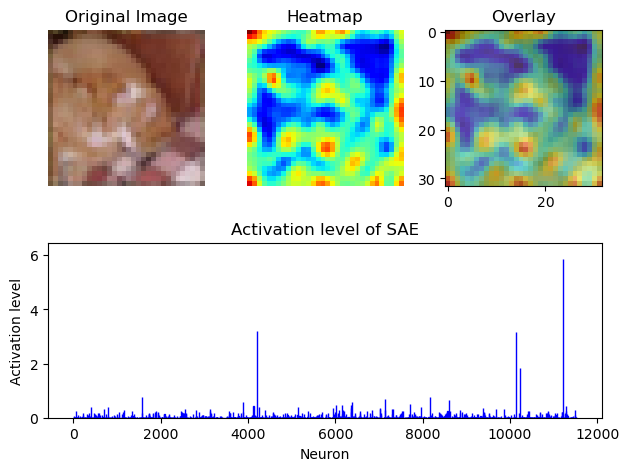

layer 1


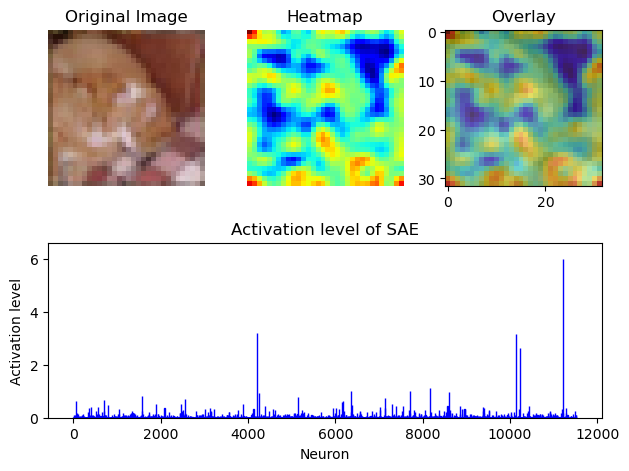

layer 2


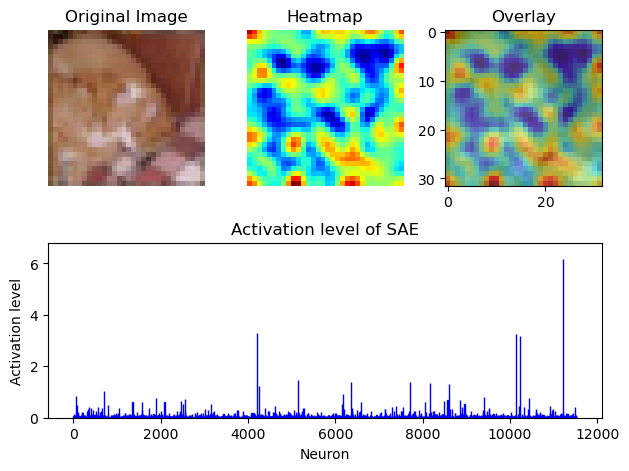

layer 3


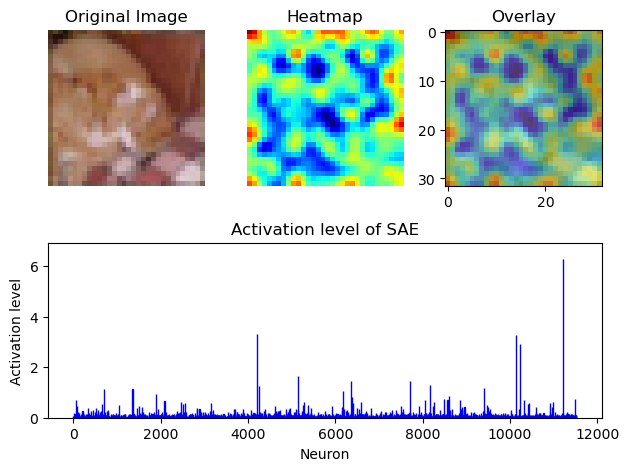

layer 4


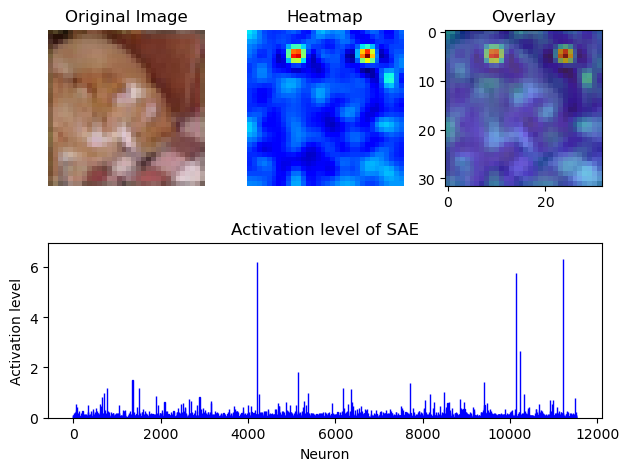

layer 5


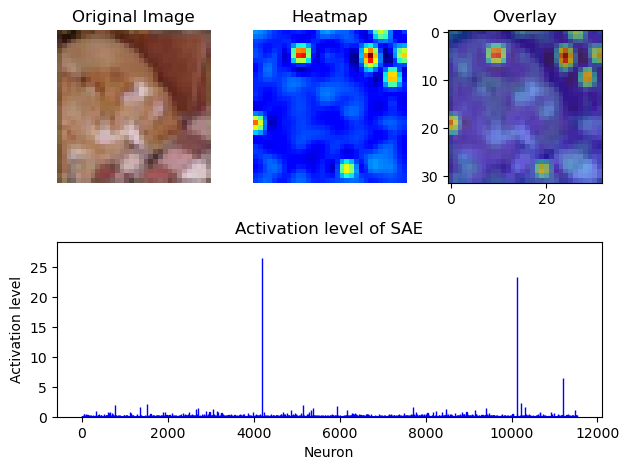

layer 6


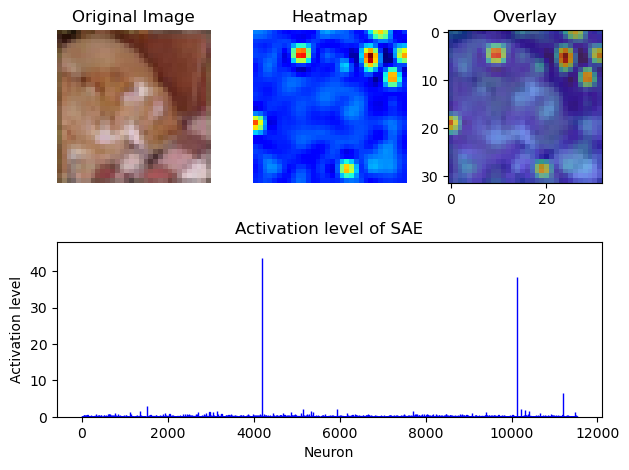

layer 7


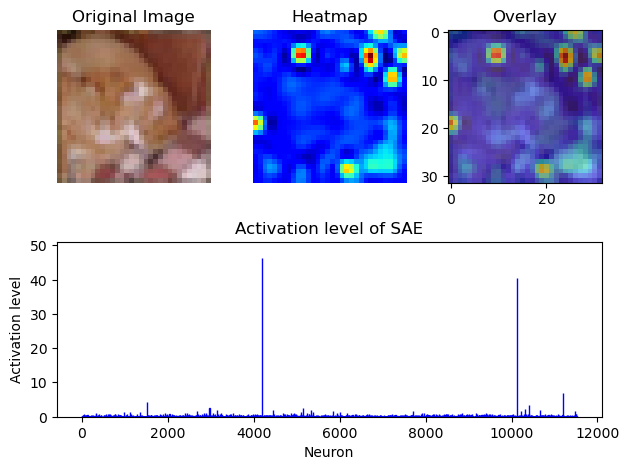

layer 8


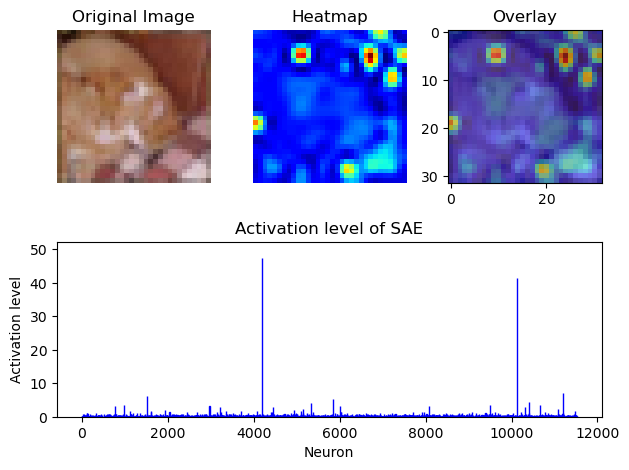

layer 9


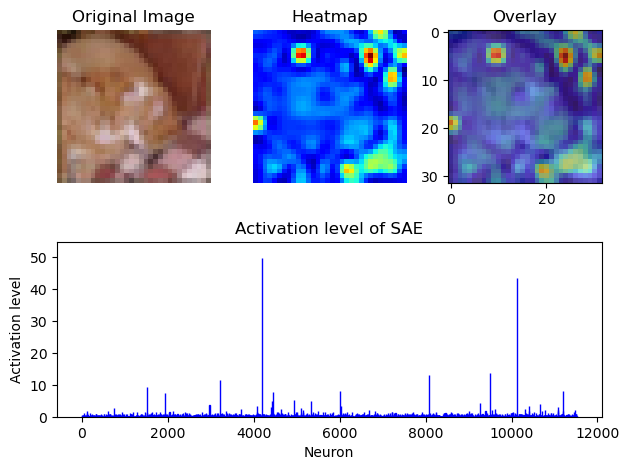

layer 10


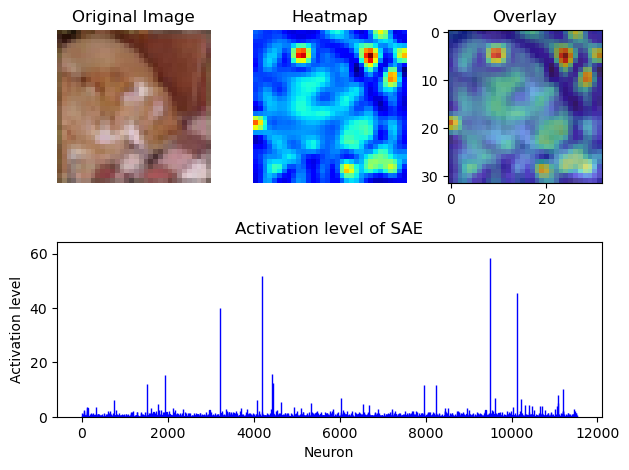

layer 11


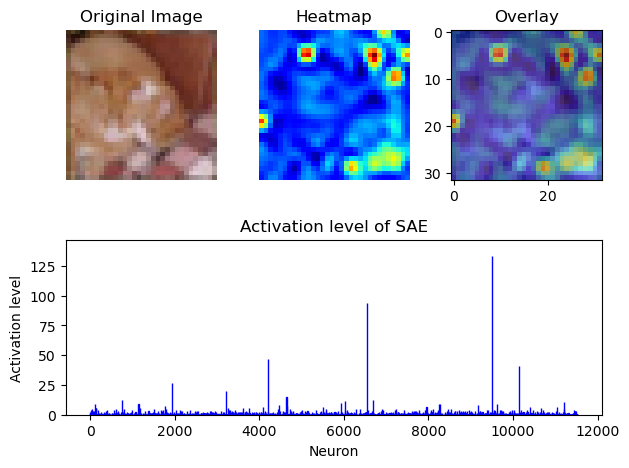

In [10]:
#run for all layers model ratio 15
for i in range(12):
    print(f'layer {i}')
    plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',input_image,layer_number = i, ratio=15, device= device)

for i in range(12):
    print(f'layer {i}')
    plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',input_image2,layer_number = i, ratio=15, device=device)

for i in range(12):
    print(f'layer {i}')
    plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',input_image3,layer_number = i, ratio=15, device=device)

## Look into layer 5 activations 

In [11]:
#layer5 most activated neuron
input_image = transforms.ToPILImage()(input_image)
input_image2 = transforms.ToPILImage()(input_image2)
input_image3 = transforms.ToPILImage()(input_image3)
input1 = feature_extractor(images=input_image, return_tensors="pt")
input2 = feature_extractor(images=input_image2, return_tensors="pt")
input3 = feature_extractor(images=input_image3, return_tensors="pt")

input1.to(device)
input2.to(device)
input3.to(device)

activation_input1 = model(**input1)['hidden_states'][6] # layer + 1 embedding
activation_input2 = model(**input2)['hidden_states'][6]
activation_input3 = model(**input3)['hidden_states'][6]

# initiate the encoder and encoder_bias for SAE
encoder = torch.randn((768*15, 768)) # encoder
nn.init.xavier_uniform_(encoder)
encoder_bias = torch.zeros(768*15) # encoder bias

# Create a SAE instance
tied_sae = TiedSAE(encoder, encoder_bias)
tied_sae.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth'))
tied_sae.to_device(device)

# Calculate the activation levels for the input patch
activation1 = tied_sae.encode(activation_input1).squeeze(0)
activation2 = tied_sae.encode(activation_input2).squeeze(0)
activation3 = tied_sae.encode(activation_input3).squeeze(0)

In [12]:
top_features_values1, top_features_indices1 = torch.topk(activation1.mean(dim=0), k=10, largest=True)
top_features_values2, top_features_indices2 = torch.topk(activation2.mean(dim=0), k=10, largest=True)
top_features_values3, top_features_indices3 = torch.topk(activation3.mean(dim=0), k=10, largest=True)
print(top_features_indices1)
print(top_features_indices2)
print(top_features_indices3)

tensor([ 4201, 10133, 11204,  1509,   776, 10105,  2366, 10124,  9467,  6401],
       device='cuda:0')
tensor([ 4201, 10133, 11204,  1509,  5933,  5139,   776,  7705,  7662,  7227],
       device='cuda:0')
tensor([ 4201, 10133, 11204, 10218,  1509,  5139,   776,  5933, 10323,  1355],
       device='cuda:0')


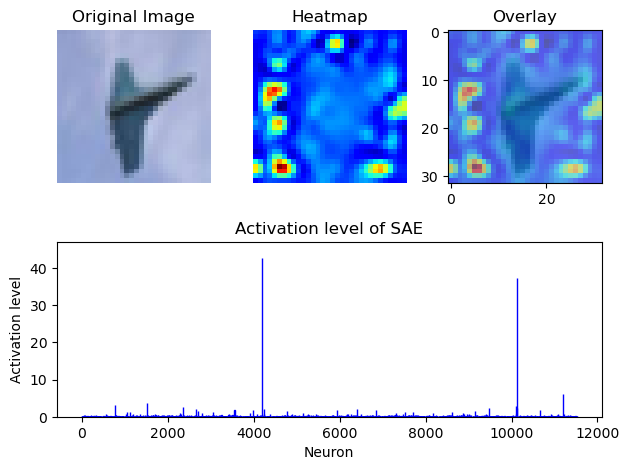

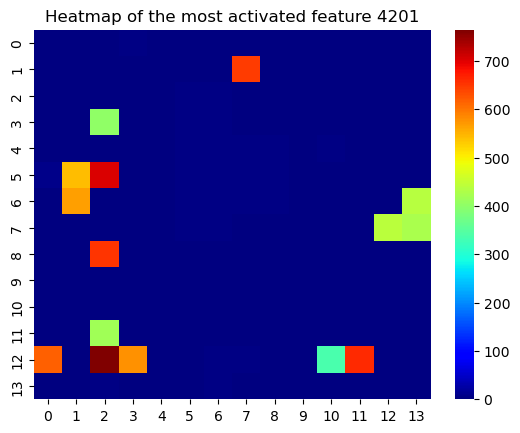

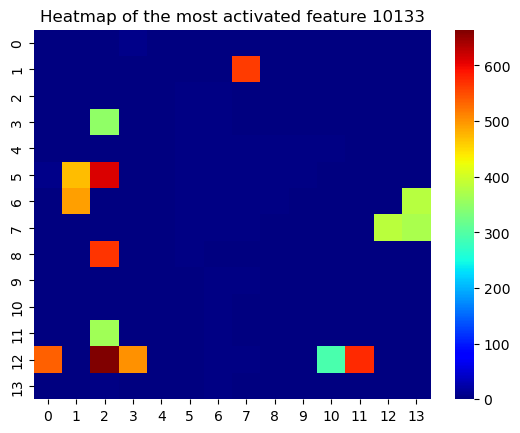

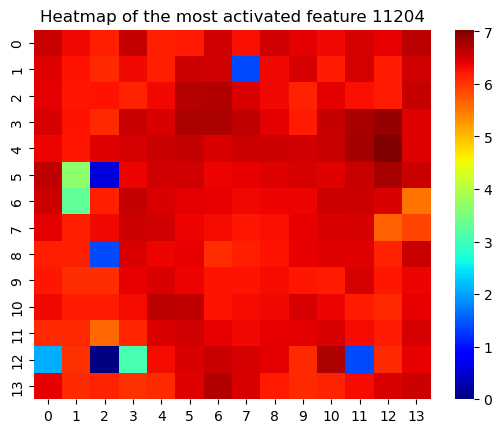

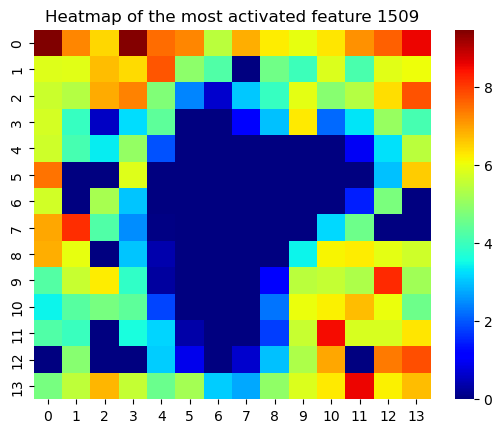

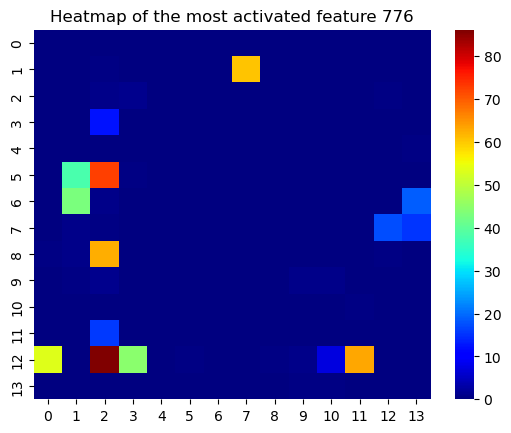

In [13]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',input_image,layer_number = 5, ratio=15, device= device)

# patches where the most activated features are located

for i in range(5):
    # Select the activations
    selected_activations = activation1[:, top_features_indices1[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Heatmap of the most activated feature {top_features_indices1[i]}')
    plt.show()


/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


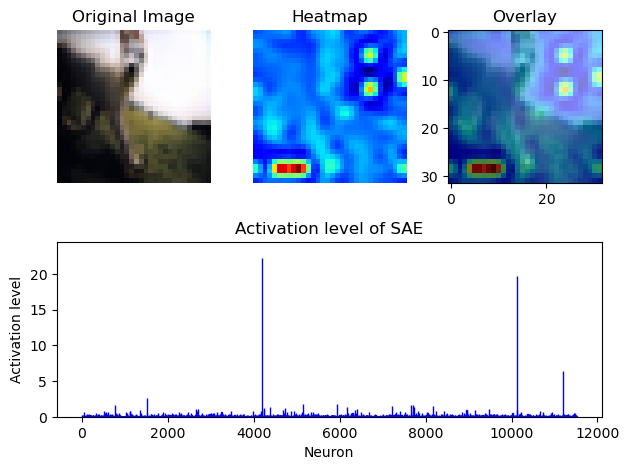

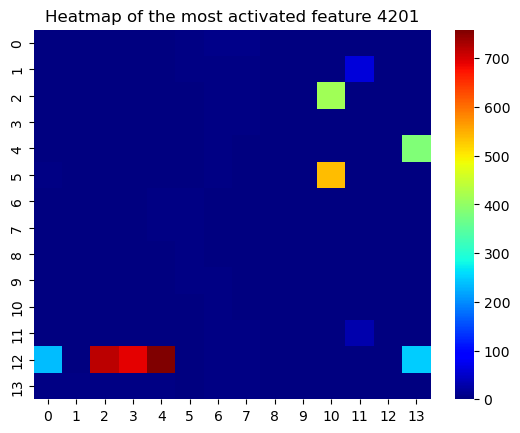

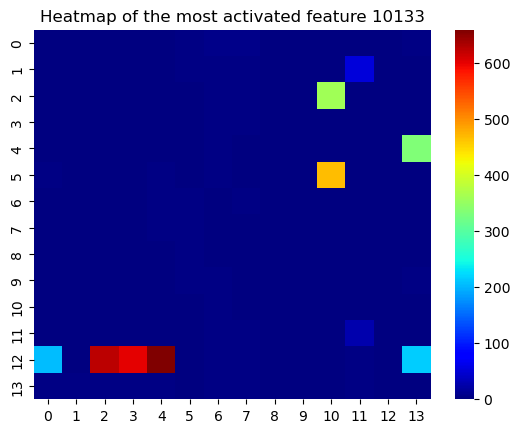

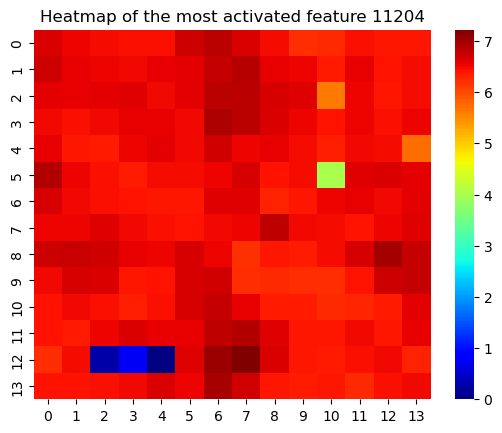

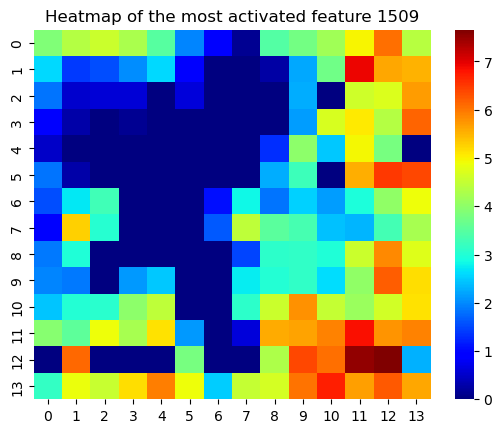

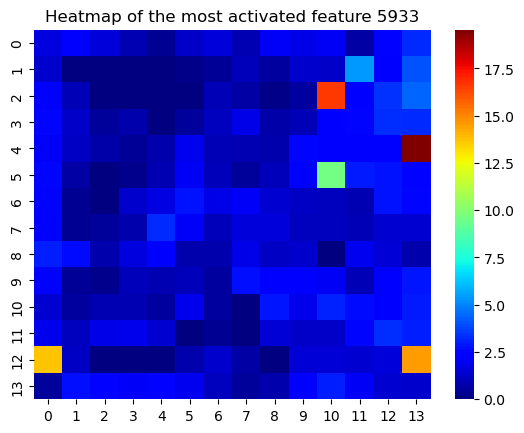

In [14]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',input_image2,layer_number = 5, ratio=15, device= device)

# patches where the most activated features are located

for i in range(5):
    # Select the activations
    selected_activations = activation2[:, top_features_indices2[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Heatmap of the most activated feature {top_features_indices2[i]}')
    plt.show()


/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


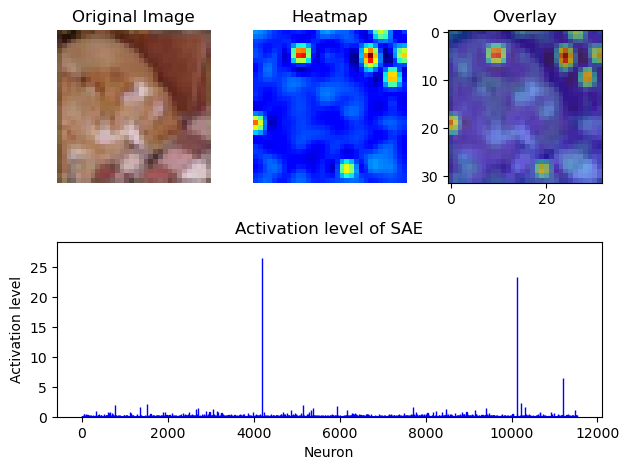

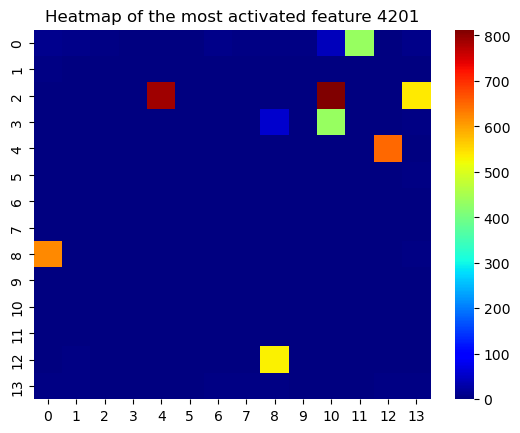

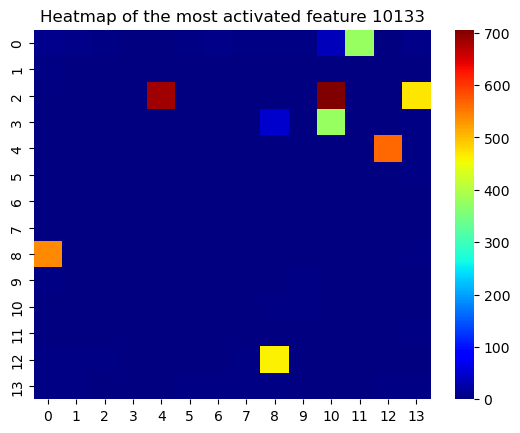

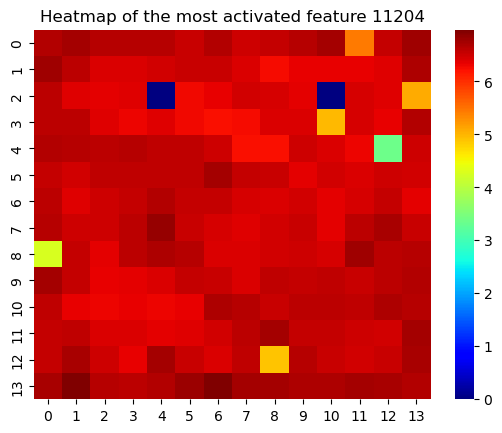

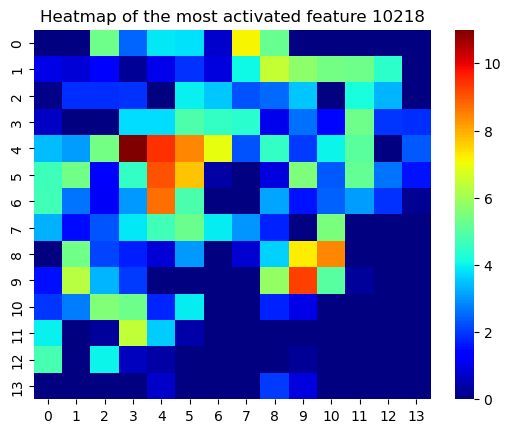

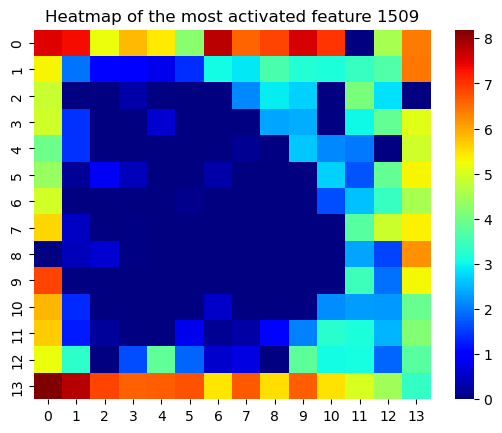

In [15]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',input_image3,layer_number = 5, ratio=15, device= device)

# patches where the most activated features are located

for i in range(5):
    # Select the activations
    selected_activations = activation3[:, top_features_indices3[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Heatmap of the most activated feature {top_features_indices3[i]}')
    plt.show()


## Look into layer 0 activations

In [16]:
#layer 0 most activated neuron

activation_input1 = model(**input1)['hidden_states'][1]
activation_input2 = model(**input2)['hidden_states'][1]
activation_input3 = model(**input3)['hidden_states'][1]

# initiate the encoder and encoder_bias for SAE
encoder = torch.randn((768*15, 768)) # encoder
nn.init.xavier_uniform_(encoder)
encoder_bias = torch.zeros(768*15) # encoder bias

# Create a SAE instance
tied_sae = TiedSAE(encoder, encoder_bias)
tied_sae.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth'))
tied_sae.to_device(device)

# Calculate the activation levels for the input patch
activation1 = tied_sae.encode(activation_input1).squeeze(0)
activation2 = tied_sae.encode(activation_input2).squeeze(0)
activation3 = tied_sae.encode(activation_input3).squeeze(0)

In [17]:
top_features_values1, top_features_indices1 = torch.topk(activation1.mean(dim=0), k=10, largest=True)
top_features_values2, top_features_indices2 = torch.topk(activation2.mean(dim=0), k=10, largest=True)
top_features_values3, top_features_indices3 = torch.topk(activation3.mean(dim=0), k=10, largest=True)
print(top_features_indices1)
print(top_features_indices2)
print(top_features_indices3)

tensor([11204,  4201, 10133,  8957,  1351,  4868,  7305,  8634,   661,  1729],
       device='cuda:0')
tensor([11204,  4201, 10133,  8166,  2471,  4126,  3032,  1583,    51,  6362],
       device='cuda:0')
tensor([11204,  4201, 10133, 10218,  8166,  1583,  7138,  8601,  3887,  6389],
       device='cuda:0')


/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


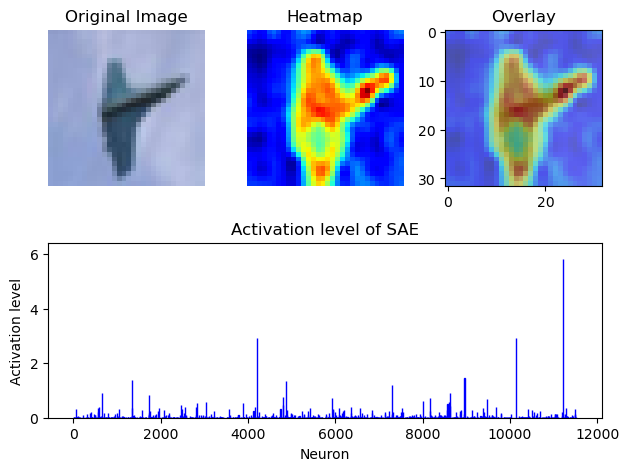

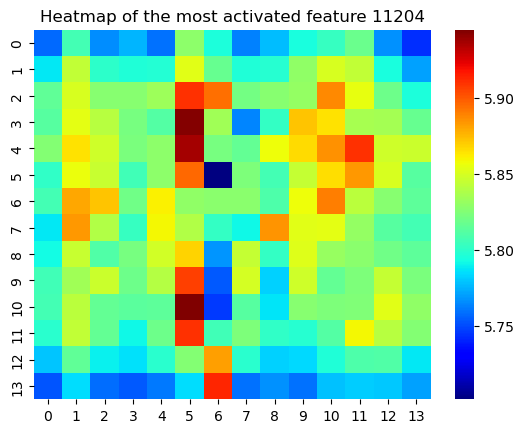

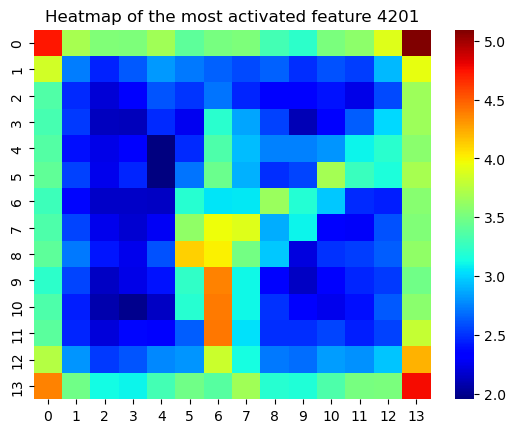

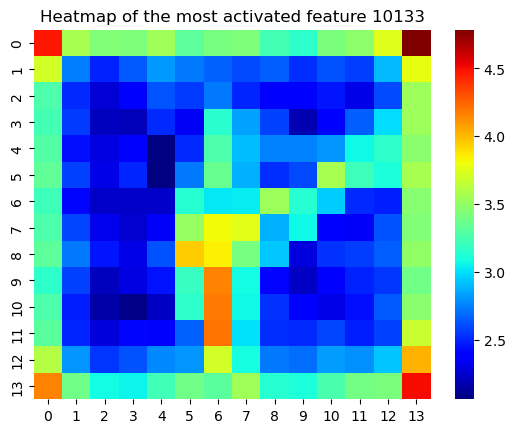

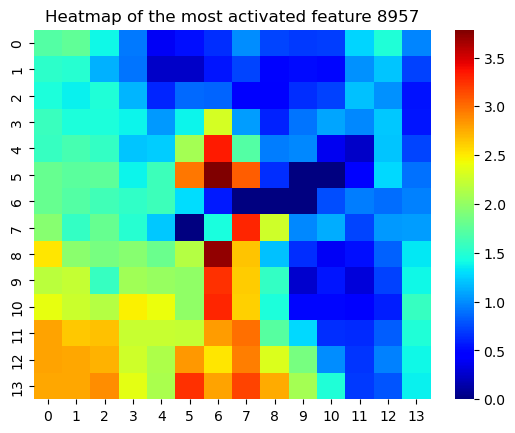

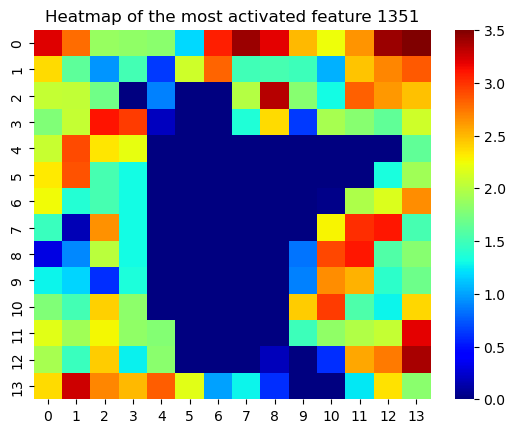

In [18]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',input_image,layer_number = 0, ratio=15, device= device)

# patches where the most activated features are located

for i in range(5):
    # Select the activations
    selected_activations = activation1[:, top_features_indices1[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Heatmap of the most activated feature {top_features_indices1[i]}')
    plt.show()


/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


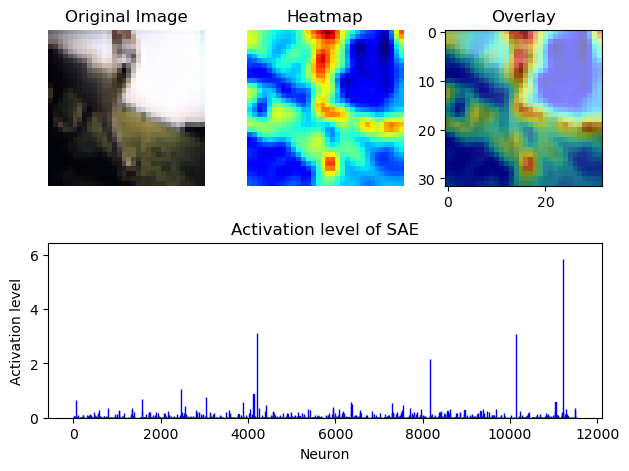

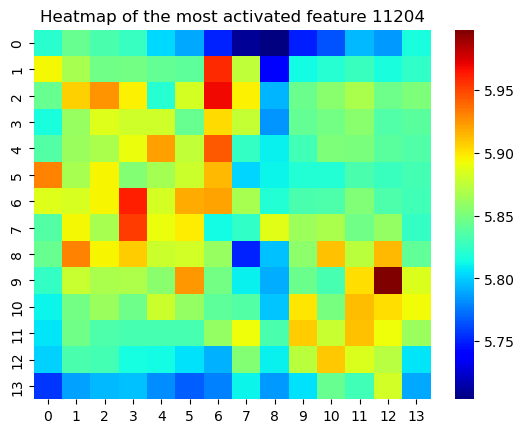

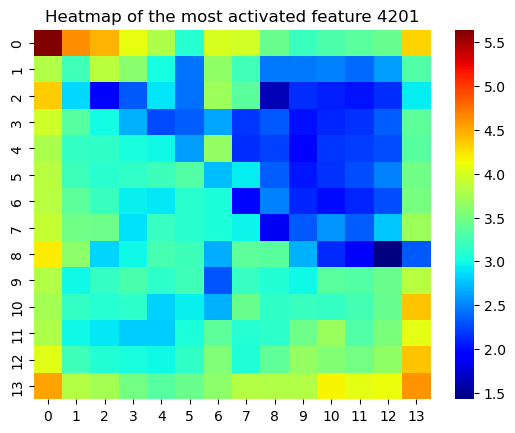

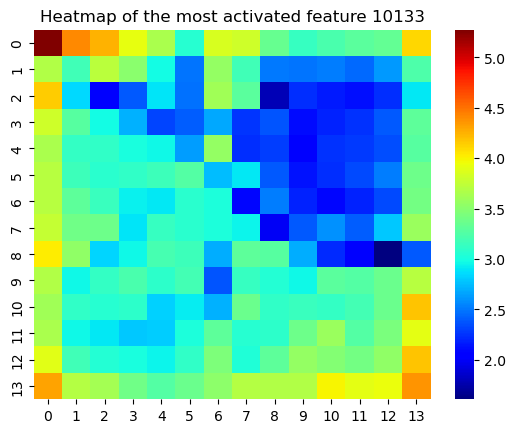

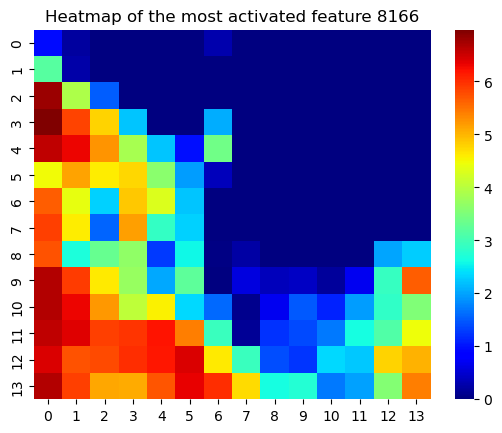

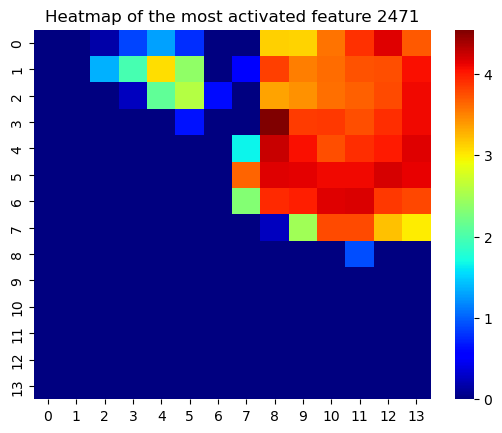

In [19]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',input_image2,layer_number = 0, ratio=15, device= device)

# patches where the most activated features are located

for i in range(5):
    # Select the activations
    selected_activations = activation2[:, top_features_indices2[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Heatmap of the most activated feature {top_features_indices2[i]}')
    plt.show()


/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


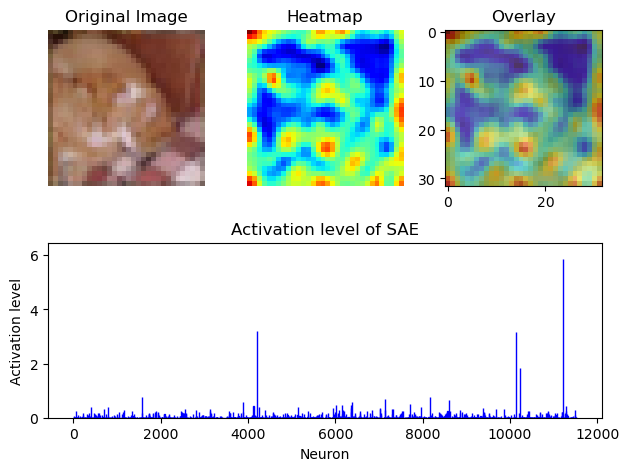

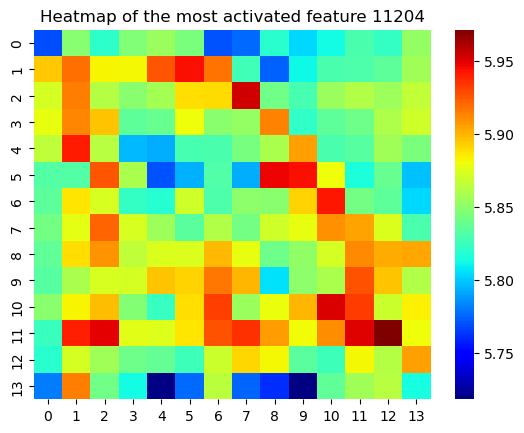

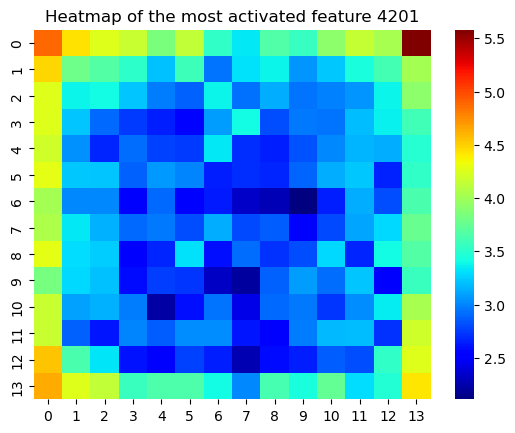

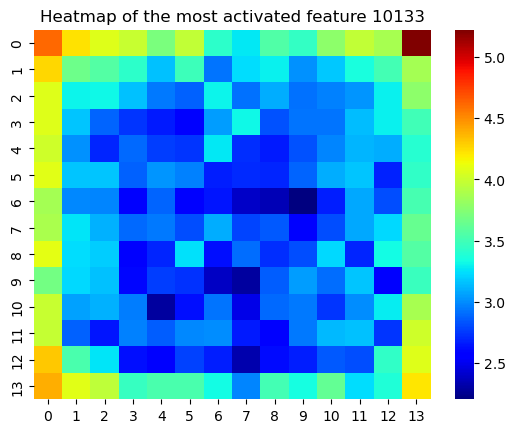

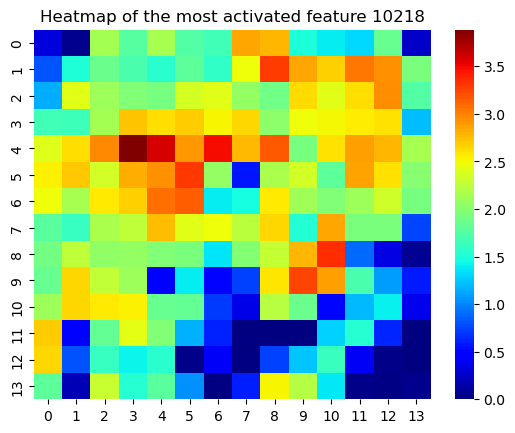

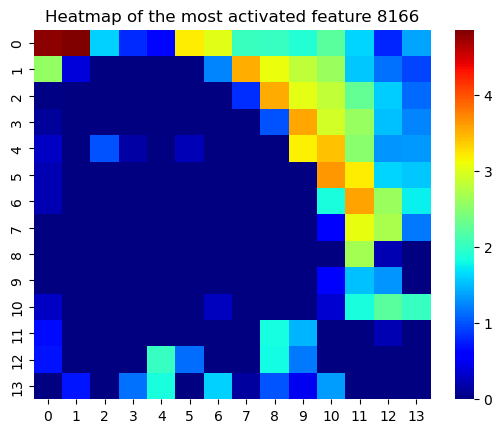

In [20]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',input_image3,layer_number = 0, ratio=15, device= device)

# patches where the most activated features are located

for i in range(5):
    # Select the activations
    selected_activations = activation3[:, top_features_indices3[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Heatmap of the most activated feature {top_features_indices3[i]}')
    plt.show()


## Look into most activated features in All layers

In [21]:
activation_inputs1 = model(**input1)['hidden_states'][1:]
activation_inputs2 = model(**input2)['hidden_states'][1:]
activation_inputs3 = model(**input3)['hidden_states'][1:]

# initiate the encoder and encoder_bias for SAE
encoder = torch.randn((768*15, 768)) # encoder
nn.init.xavier_uniform_(encoder)
encoder_bias = torch.zeros(768*15) # encoder bias

# Create a SAE instance
tied_sae = TiedSAE(encoder, encoder_bias)
tied_sae.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth'))
tied_sae.to_device(device)

# Calculate the activation levels for the input patch
activations_1 =[]
activations_2 =[]
activations_3 =[]


for i in range(12):
    activations_1.append(tied_sae.encode(activation_inputs1[i]).squeeze(0))
    activations_2.append(tied_sae.encode(activation_inputs2[i]).squeeze(0))
    activations_3.append(tied_sae.encode(activation_inputs3[i]).squeeze(0))


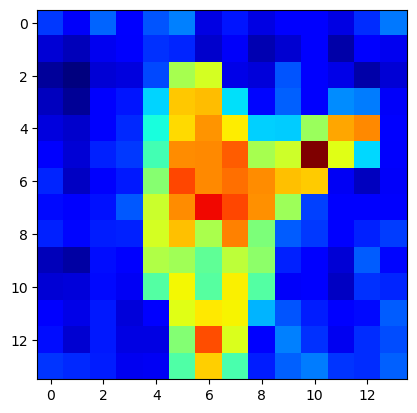

In [22]:
plt.imshow(activations_1[0][1:].mean(dim=1).cpu().detach().numpy().reshape(14,14), cmap='jet')

/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


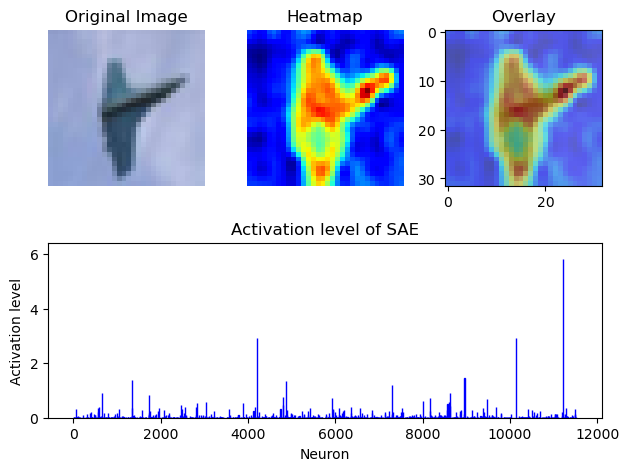

In [23]:
# plot activation of layer of study  
plot_activation('nateraw/vit-base-patch16-224-cifar10',f'SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth',input_image,layer_number = 0, ratio=15, device= device)


In [24]:
top_features1 = []
top_features2 = []
top_features3 = []
for i in range(12):
    # Detach the tensors before passing them to torch.topk()
    tensor1 = activations_1[i].mean(dim=0).detach().cpu()
    tensor2 = activations_2[i].mean(dim=0).detach().cpu()
    tensor3 = activations_3[i].mean(dim=0).detach().cpu()

    top_features1.append(torch.topk(tensor1, k=10, largest=True).indices)
    top_features2.append(torch.topk(tensor2, k=10, largest=True).indices)
    top_features3.append(torch.topk(tensor3, k=10, largest=True).indices)

In [25]:
print("Image 1")
[print(i) for i in top_features1]

print("Image 2")
[print(i) for i in top_features2]

print("Image 3")
[print(i) for i in top_features3]

Image 1
tensor([11204,  4201, 10133,  8957,  1351,  4868,  7305,  8634,   661,  1729])
tensor([11204,  8957, 10133,  4201,  7305,  9467,  8166,  2550,  8601,  2471])
tensor([11204,  8957, 10133,  4201,  7305,  9467,  8166,  6363,  4157,  4243])
tensor([11204,  4201, 10133,  9467,  6371,  6401,  1509,  7305,  8957, 10124])
tensor([ 4201, 10133, 11204,   776,  9467,  1509,  6401, 10657, 10124, 10105])
tensor([ 4201, 10133, 11204,  1509,   776, 10105,  2366, 10124,  9467,  6401])
tensor([ 4201, 10133, 11204, 10105,  1125,  4233,  3554,  1509,  8607,  2366])
tensor([ 4201, 10133,  8607, 11204, 10105,  1125,  4233,  9375,  3554,  1509])
tensor([ 4201, 10133,  8607,  9375, 11204,  1509, 10105,  1125,  6273,  3554])
tensor([ 4201, 10133,  9375, 11057, 10258, 10928,  1509, 11204,  1125,  3554])
tensor([11057,  4201, 10133, 10928,  6525,  9375, 11072,  4430,  6550,  1509])
tensor([11057, 10928,  4201, 10133,  9375,  9527,  4602,  1183,  5933,  3199])
Image 2
tensor([11204,  4201, 10133,  8166, 

[None, None, None, None, None, None, None, None, None, None, None, None]

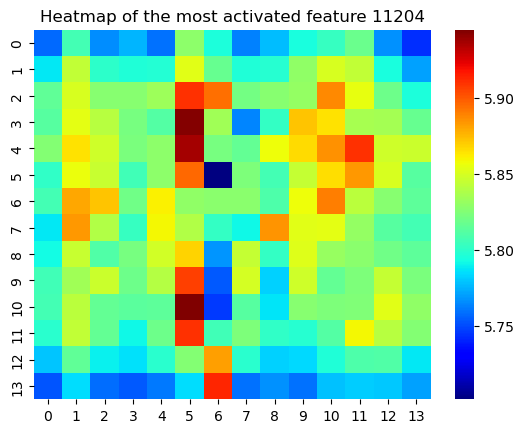

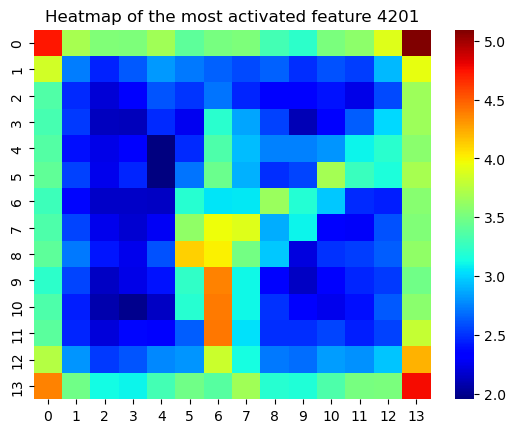

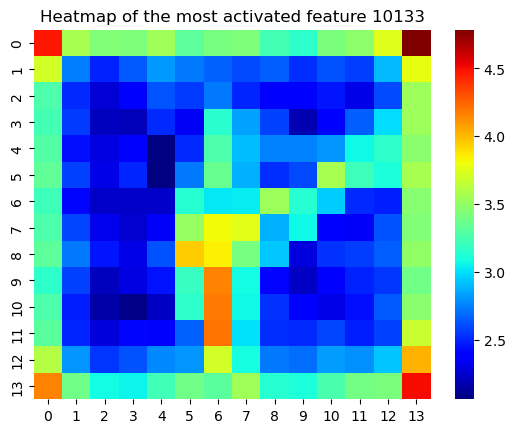

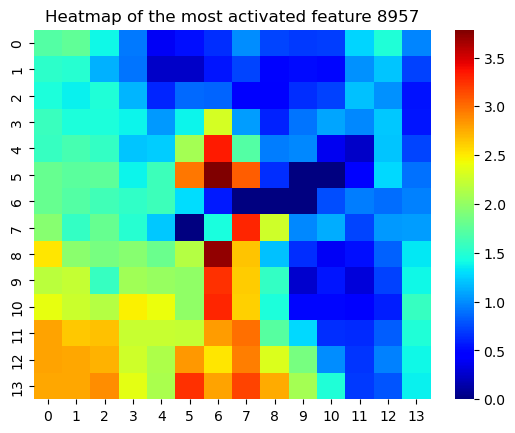

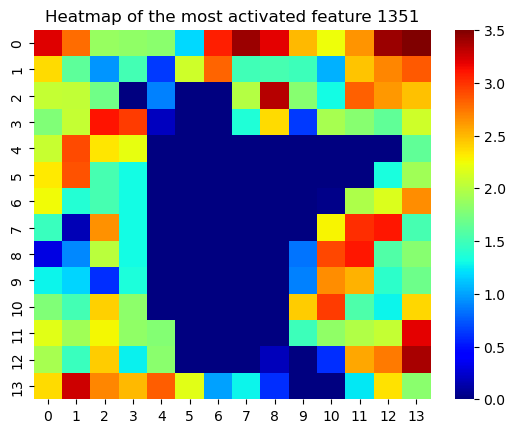

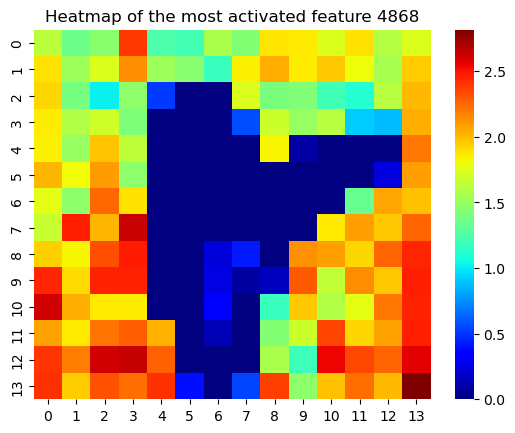

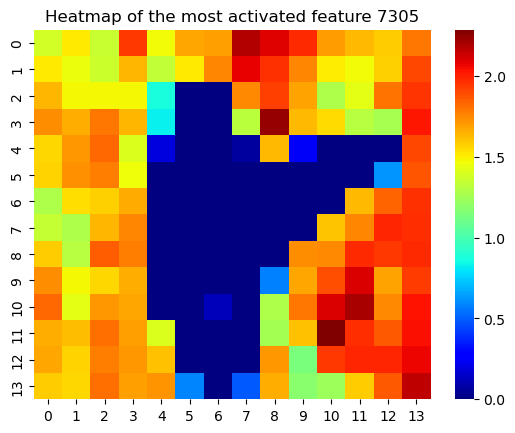

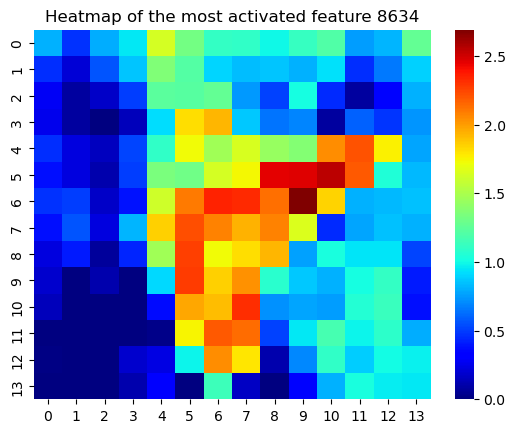

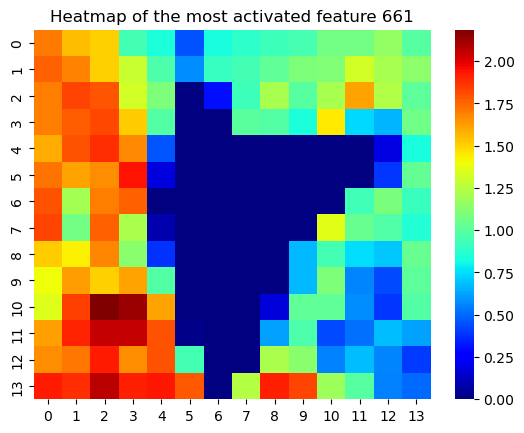

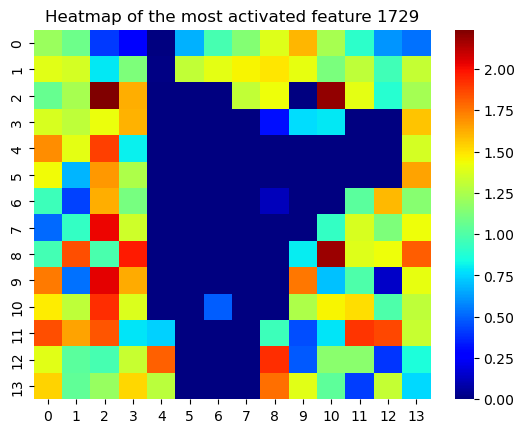

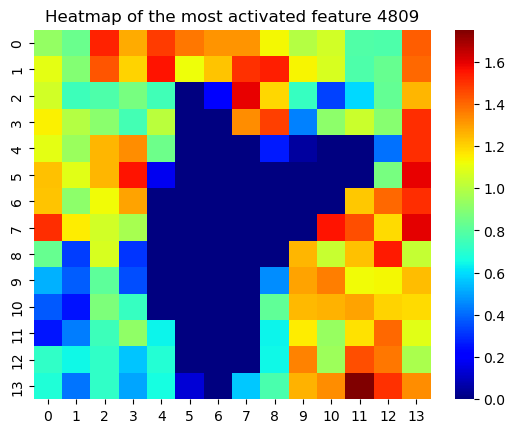

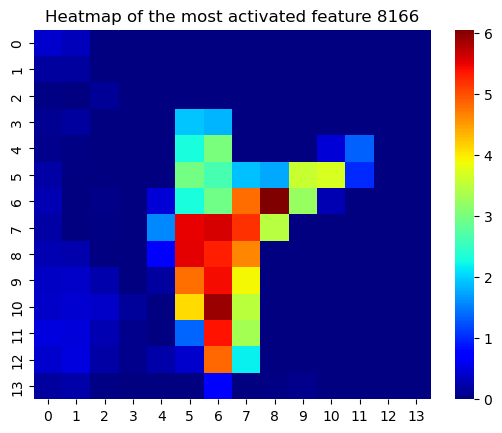

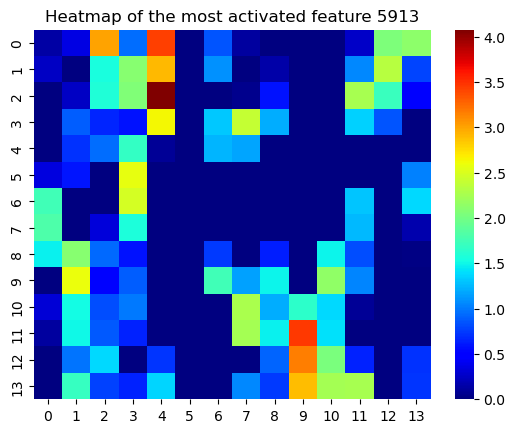

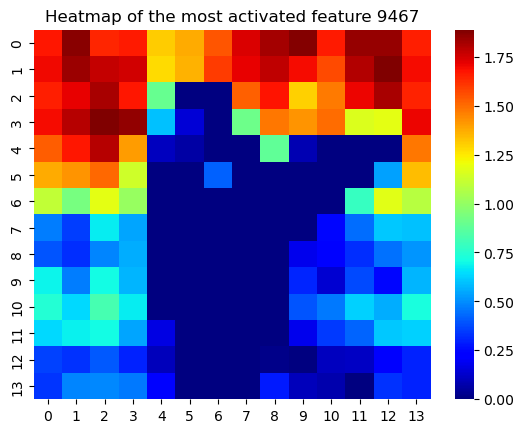

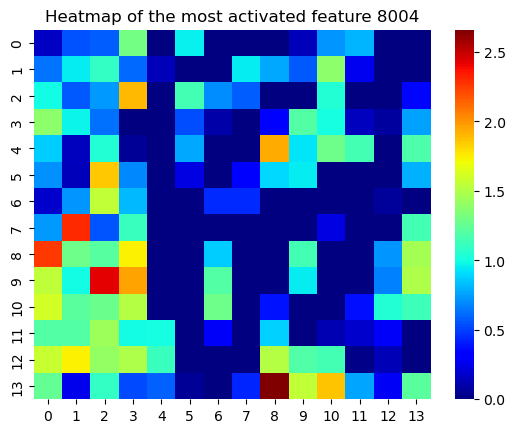

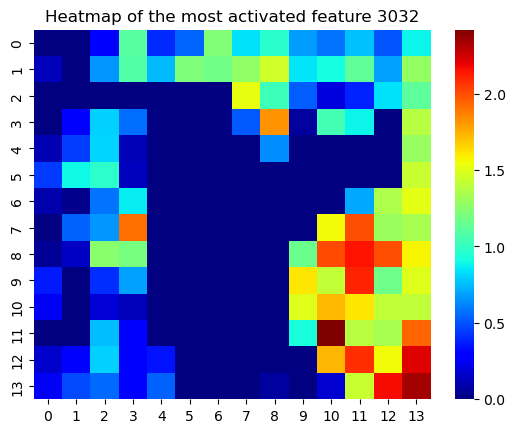

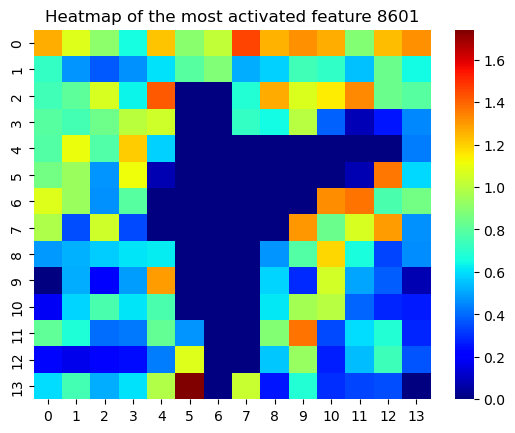

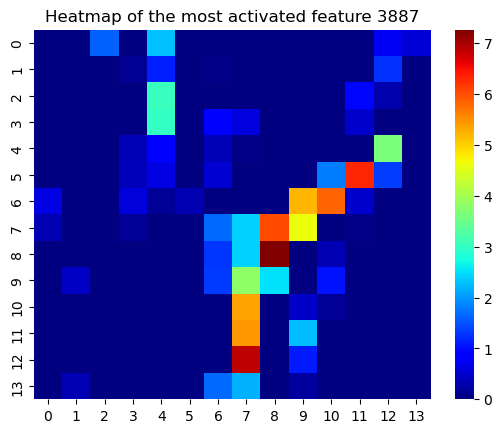

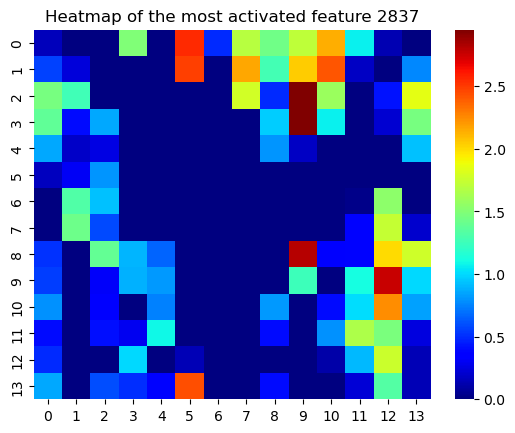

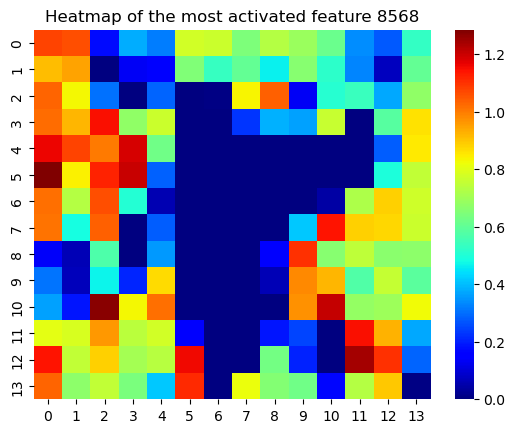

In [26]:
#top 20 most activated neurons
_, top = torch.topk(activation1.mean(dim=0), k=20, largest=True)
for i in range(20):
    # Select the activations
    selected_activations = activation1[:, top[i]][1:]

    # Reshape the activations into a 14x14 matrix
    heatmap_data = selected_activations.reshape(14, 14)

    # Plot the heatmap
    sns.heatmap(heatmap_data.cpu().detach().numpy(), cmap='jet')
    plt.title(f'Heatmap of the most activated feature {top[i]}')
    plt.show()

In [27]:
# extract top 10 features that activated in a input across all layers
def get_top_indices(top_features, num_top=10):
    tops = []
    for i in top_features:
        tops.append(i.cpu().detach().numpy())
    tops = np.concatenate(tops)

    # Count the occurrences of each value
    value_counts = Counter(tops)

    # Create a dictionary with value and counts
    value_counts_dict = dict(value_counts)
    sorted_counts = sorted(value_counts_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_indices = [index for index, _ in sorted_counts[:num_top]]
    
    return sorted_indices

# create heatmap for most activated neurons in each layer

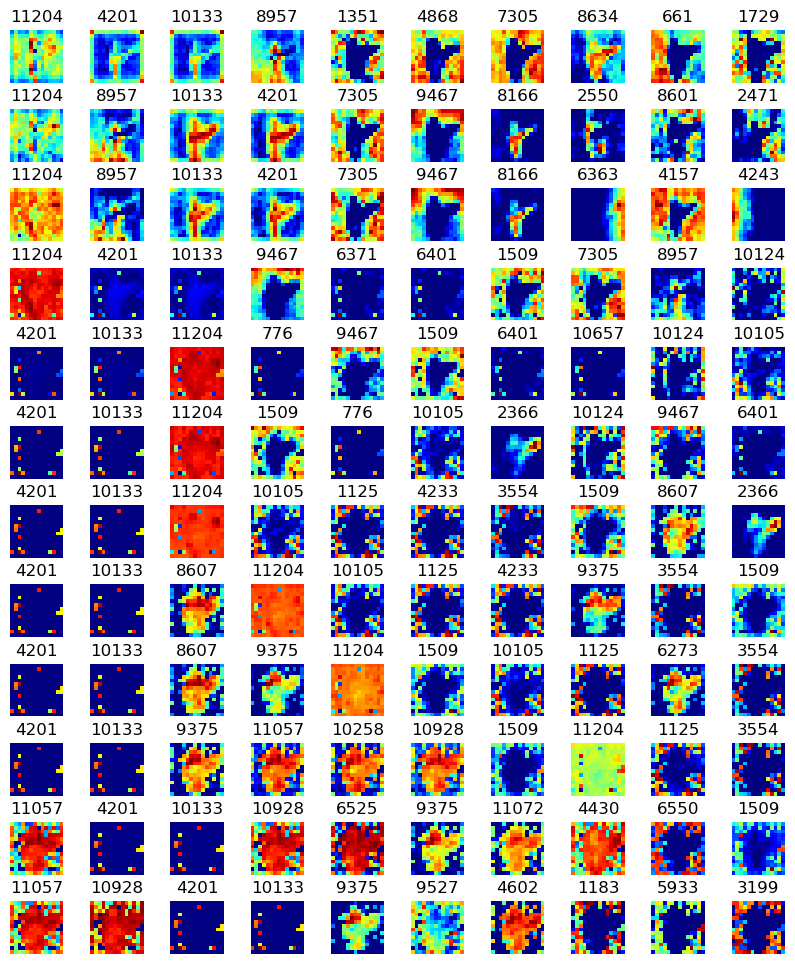

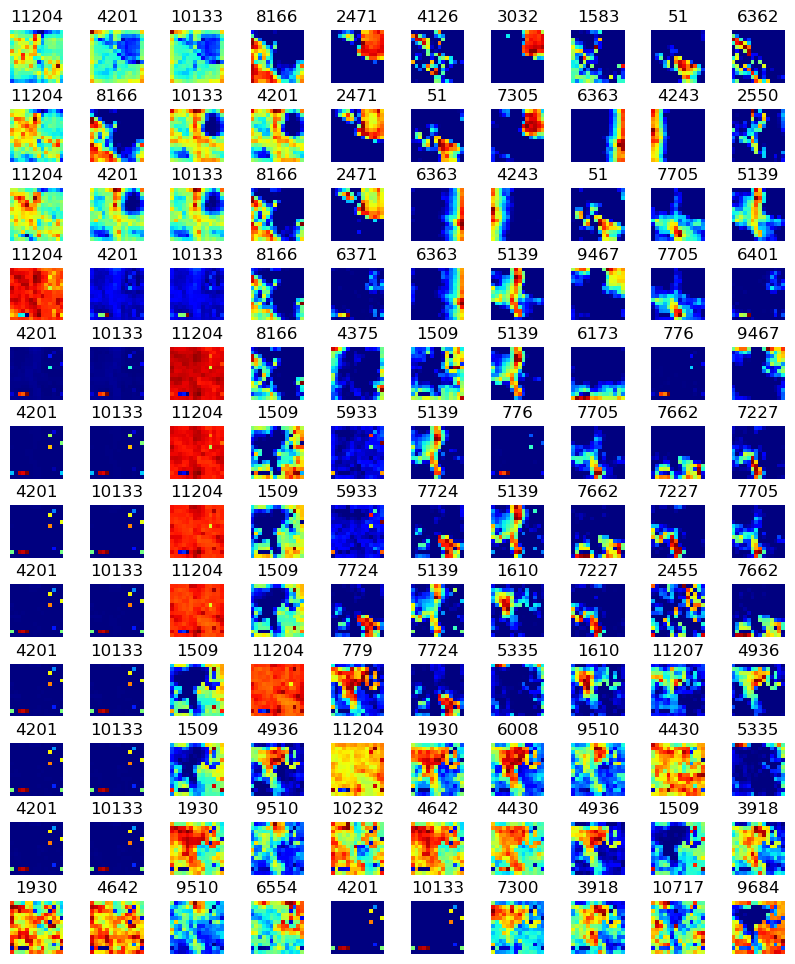

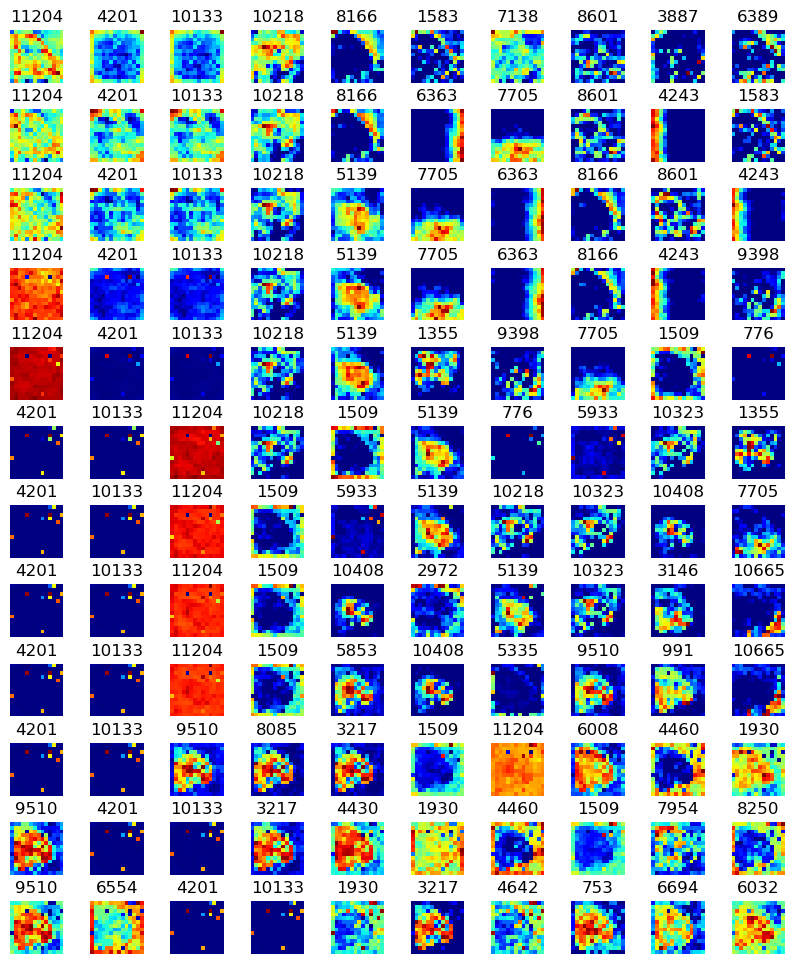

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to create a heatmap
def create_heatmap(activations, top_features):
    fig, axs = plt.subplots(12, 10, figsize=(10, 12))
    for i, layer_features in enumerate(top_features):
        for j, feature in enumerate(layer_features):
            ax = axs[i, j]
            sns.heatmap(activations[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
            ax.set_title(f'{feature}')
            ax.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
    plt.show()

# Call the function for each image
create_heatmap(activations_1, top_features1)
create_heatmap(activations_2, top_features2)
create_heatmap(activations_3, top_features3)